In [6]:
import requests
import base64
import json
from IPython.display import Image

In [18]:
api_key = '<api-key>'
base_url = '<endpoint>'

# API Examples

The api is a REST API that exposes HTTP endpoints. The following demonstrates using Python's request library, but you can use any technique that is capable of making HTTP requests to access the API. 


## Authenticating & Headers

Your api key should be passed as a Bearer token in the `authorization` header.

The value of the `Content-Type` header should be `application/json`.

In [8]:
endpoint = f"{base_url}/api/v1/chat/completions"

headers = {
    'accept': 'application/json',
    'authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json'
}

## Minimal Chat Example

The simplest possible chat with just a model and a user prompt.

In [60]:
data = {
  "model": "claude_3_haiku",
  "messages": [
    {
      "role": "user",
      "content": "Hello"
    }
  ]
}

In [62]:
resp = requests.post(endpoint, json=data, headers=headers)
if resp.status_code >= 300:
    print("error", resp.status_code)

response_object = resp.json()
response_object

{'object': 'chat.completion',
 'created': 1749690737,
 'model': 'claude_3_haiku',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': 'Hi there! How are you doing today? Is there anything I can help you with?'},
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 8, 'completion_tokens': 21, 'total_tokens': 29}}

## Using a system prompt

The `messages` array can contain mutlple content items of various types. Including a system prompt influences how the model behaves.

In [63]:
data = {
  "model": "claude_3_5_sonnet",
  "messages": [
    {
      "role": "system",
      "content": "You are a pirate and only speak in pirate"
    },
    {
      "role": "user",
      "content": "Hello"
    }
  ]
}

In [64]:
resp = requests.post(endpoint, json=data, headers=headers)
if resp.status_code >= 300:
    print("error", resp.status_code)

response_object = resp.json()
response_object['choices'][0]['message']['content']

'Yarr, ahoy there matey! *adjusts eye patch* What brings ye to these waters today? I be ready to help any scurvy dog that crosses me path, so long as they be respectful-like!'

## Including image data with prompt

Images must be encoded as a data URI like`data:image/jpg;base64,<base64 data>`

Include the image as another content item with

```
{
  "type": "image_url",
  "image_url": { 
    "url":encoded  # your base64 encoded string
  },
  "detail": "auto"
}
```

Below we have a request object with three items:
1. System prompt
2. User prompt
3. Image content

The example also demonstrates crafting the prompt to encourage the model to respond with valid JSON data.

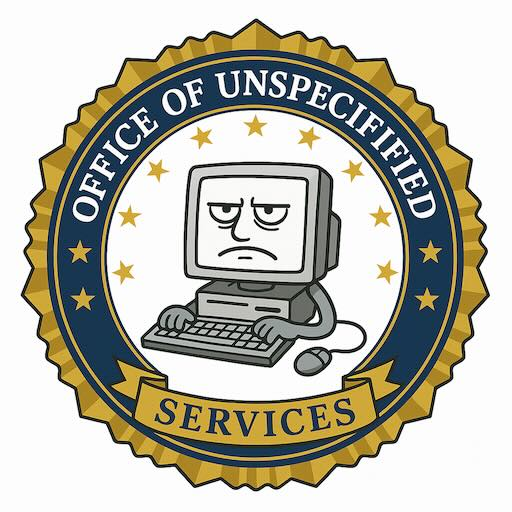

In [65]:
seal_image_path = "images/ous_white.jpg"
stapler_image_path = "images/red_stapler.jpg"
Image(filename=seal_image_path)

In [66]:
def make_prompt(image_path, description):
    image = Image(filename=image_path)
    image_bytes = image.data
    # encode image bytes as base64
    # and create a data url
    s = base64.b64encode(image_bytes).decode('utf-8')
    encoded = 'data:image/png;base64,' + s
    return {
        "model": "gemini-2.0-flash",
        "messages": [
            {
                "role": "system",
                "content": """
                    I want to directly parse your response as json. Do not include any other text other than the plain json. 
                    Do not not include the word json, do not include new line characters. Only the exact json text.
                    """
            },
            {
                "role": "user",
                "content": [
                {
                  "type": "text",
                  "text": f"""I have the following description of this image:
                  {description} 
                  I would like to know if this description as genally correct. The description does not need to be 
                  specfic or detailed. The general category is still considered correct if it matches
                  the image. Format your answer as a json object with two pieces of information, a boolean indicating
                  whether the teh description matches, and a description, which is your identification of the image:
                  {{"is_correct": boolean indicating if the description is generally correct, "description":your description of the image.}}.
                  """
                },
                {
                  "type": "image_url",
                  "image_url": {
                    "url": encoded
                  },
                  "detail": "auto"
                }
                ]
            }
        ]
    }


In [67]:
prompt = make_prompt(seal_image_path, "a red stapler")

resp = requests.post(endpoint, json=prompt, headers=headers)
response_object = resp.json()
response_content = response_object['choices'][0]['message']['content']
json.loads(response_content)

{'is_correct': False,
 'description': 'Seal of the Office of Unspecified Services with a cartoon computer.'}

## Including documents

Similar to images, documents are included as another content item with base 64 data.

In [68]:
def make_document_prompt(model, document_path, prompt):
    with open(document_path, 'rb') as f:
        pdf_bytes = f.read()
        pdf_base_64 = base64.b64encode(pdf_bytes).decode('utf-8')
        encoded = 'data:application/pdf;base64,' + pdf_base_64
        
    return {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [
                {
                  "type": "text",
                  "text": prompt
                },
                {
                  "type": "file",
                  "file_name": "Test",
                  "file": {
                    "file_data": encoded
                  }
                }
                ]
            }
        ]
    }

In [69]:
prompt = make_document_prompt(
    "gemini-2.0-flash",
    "documents/AWorldofLovesample.pdf",
    "Please summarize this document."
)

resp = requests.post(endpoint, json=prompt, headers=headers)
print(resp)
response_object = resp.json()
response_object['choices'][0]['message']['content']

<Response [200]>


"This excerpt describes the setting of a summer morning in Ireland, focusing on the landscape surrounding a somewhat dilapidated mansion called Montefort. The sun rises, casting a coppery light on the fields, rocks, and the river gorge. The house, though once lordly, now shows signs of neglect, with overgrown areas and decaying structures. A girl named Jane, dressed in an Edwardian muslin dress, emerges from the house and leans against an obelisk, re-reading a letter. She is described as beautiful, with a combination of naivety and a classical grace. Inside one of the rooms, however, a claret-red dusk is only interrupted by the buzzing of a bluebottle against the ceiling. The room's decor is rich, but the details hint at disarray and a potential inhabitant still asleep in the fourposter bed."

## Model Differences

Different models have different capabilities. The document`AWorldofLovesample.pdf`, which we passed to the model above, is a scanned PDF that only contains an image of the text — it doesn't contain any text content. Gemini is capable of performing OCR on the image and extracting text from it.

On the other hand, Claude does not do this (at the moment) and responds that it sees a blank doucment. To effectively use this API, it is important to understand the differences between the underlying models.

In [70]:
prompt = make_document_prompt(
    "claude_3_haiku",
    "documents/AWorldofLovesample.pdf",
    "Please summarize this document."
)

resp = requests.post(endpoint, json=prompt, headers=headers)
response_object = resp.json()
response_object['choices'][0]['message']['content']

'I apologize, but I cannot summarize the document because the document content is empty. The document appears to have no text or information within it, even though it is listed as being from "Untitled.pdf".'

# Embeddings

In [12]:
endpoint = f"{base_url}/api/v1/embeddings"

headers = {
    'accept': 'application/json',
    'authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json'
}

In [72]:
request = {
  "model": "cohere_english_v3",
  "encodingFormat": "float",
  "input": [
      "Sweet is the breath of morn, her rising sweet, With charm of earliest birds",
      "With Midnight to the North of Her — And Midnight to the South of Her — And Maelstrom — in the Sky"
  ],
  "input_type": "search_document"
}


In [73]:
resp = requests.post(endpoint, json=request, headers=headers)
result = resp.json()

In [74]:
result['data'][0]['embedding'][0:10]

[-0.0036468506,
 -0.023422241,
 -0.038757324,
 -0.038635254,
 -0.008544922,
 -0.0076293945,
 0.004508972,
 0.022476196,
 0.0019721985,
 0.017059326]

## Using embeddings for simple clustering

Embeddings are frequently used for [Retrieval Augmented Generation (RAG)](https://en.wikipedia.org/wiki/Retrieval-augmented_generation)) applications. But the semantic data captured in the embedding vectors has uses beyond RAG. 

This is a simple example that creates embeddings for 96 headlines. (We choose 96 here for simplcity since Cohere allows us to embed up to 96 documents in one call). These embeddings are put through a dimension reduction algorithm and then plotted showing the clustering based on semantic information.

In [3]:
# If you need to install these:
# intall umap-learn not umap
# !pip -q install datasets

import random
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from datasets import load_dataset

## Create a small corpus of new headlines

This uses a dataset provided by [Hugging Face datatest](https://huggingface.co/datasets/sh0416/ag_news) and selects a random sample with equal representation from three catagories.

In [2]:
dataset = load_dataset('ag_news', split='train')  # 120k rows
label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

target_labels = [0, 1, 3]  # World, Sports, Sci/Tech
sample_size = 32

rows = []
for lbl in target_labels:
    subset = [r for r in dataset if r['label'] == lbl]
    rows.extend(random.sample(subset, sample_size))

texts = [r['text'] for r in rows]
labels = [label_names[r['label']] for r in rows]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [4]:
print(f"Loaded {len(texts)} headlines: {[f'{label}={labels.count(label)}' for label in set(labels)]}\n")
print("Example text:", texts[0])

Loaded 96 headlines: ['World=32', 'Sci/Tech=32', 'Sports=32']

Example text: Budget fight deals setback to Sharon The government of Prime Minister Ariel Sharon was thrown into crisis last night after Israel #39;s parliament rejected the proposed 2005 budget and Sharon 


## Use the API to get embeddings for each headline

Because we limited the number of headlines to 96, we can do this in one request to the API. If we had a larger set, we would need to split them into groups of 96. If the documents were larger than headlines, we would also need to split documents into a size smaller than the Cohere token limit.

In [13]:
request = {
  "model": "cohere_english_v3",
  "encodingFormat": "float",
  "input": texts,
  "input_type": "clustering"
}

resp = requests.post(endpoint, json=request, headers=headers)
result = resp.json()

In [14]:
raw_embeddings = [data['embedding'] for data in result['data']]
embeddings = np.array(raw_embeddings)
embeddings.shape

(96, 1024)

## Reduce dimensions

Cohere embeddings have 1024 dimensions. This allows the embedding to capture semantic meaning on many different layers, but also makes it challenging to visualize. [UMAP learn](https://umap-learn.readthedocs.io/en/latest/) uses a non-linear dimensionality-reduction algorithm that tries to keep points that are close together in the high-dimensional space close together in the low-dimensional map. This is useful for visualizations. 

From the plot below, we can see that we were able to effectively cluster these headlines by category just from the text of the headlines.

In [16]:
reducer = umap.UMAP(random_state=42, n_jobs=1, min_dist=0.2)
emb_2d = reducer.fit_transform(embeddings)

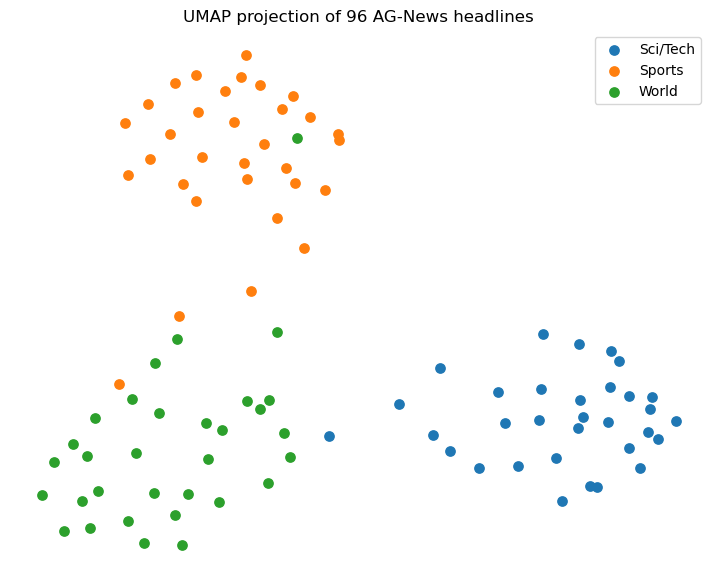

In [17]:
plt.figure(figsize=(9, 7))
unique_labels = sorted(set(labels))
colors = {lbl: idx for idx, lbl in enumerate(unique_labels)}

for lbl in unique_labels:
    idxs = [i for i, label in enumerate(labels) if label == lbl]
    plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=lbl, s=45)

plt.title('UMAP projection of 96 AG‑News headlines')
plt.legend()
plt.axis('off')
plt.show()